In [1]:
from scapy.all import rdpcap, IP, Ether, CookedLinux
import os
import numpy as np

def remove_ip(packet):
    # Neutralize MAC addresses
    if Ether in packet:
        packet[Ether].src = "00:00:00:00:00:00"
        packet[Ether].dst = "00:00:00:00:00:00"
    elif CookedLinux in packet:
        packet[CookedLinux].src = "00:00:00:00:00:00"
        
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'
        del packet[IP].chksum

        # Clear transport-layer checksums
        if packet.haslayer("TCP"):
            del packet["TCP"].chksum
        elif packet.haslayer("UDP"):
            del packet["UDP"].chksum
    return packet

def packet_to_bytes(pkt, max_len):
    pkt = remove_ip(pkt)
    raw = bytes(pkt)
    if len(raw) > max_len:
        return raw[:max_len]
    else:
        return raw.ljust(max_len, b'\x00')  # pad with zeros

def extract_raw_bytes_from_folder(folder_path, max_len=100):
    all_features = []
    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            features = [packet_to_bytes(pkt, max_len) for pkt in packets]
            all_features.extend(features)
    # Convert to numpy array
    return np.array([np.frombuffer(x, dtype=np.uint8) for x in all_features])

In [61]:
from scapy.all import rdpcap, wrpcap

def extract_raw_bytes_and_save_from_folder(folder_path, max_len=100, save_pcap_path=None):
    all_features = []
    all_packets = []

    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            for pkt in packets:
                pkt = remove_ip(pkt)
                all_packets.append(pkt)
                raw = bytes(pkt)
                raw_padded = raw.ljust(max_len, b'\x00')[:max_len]
                all_features.append(np.frombuffer(raw_padded, dtype=np.uint8))

    if save_pcap_path:
        wrpcap(save_pcap_path, all_packets)

    return np.array(all_features), all_packets  # X_attack, packets_attack


attack_folder = r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack"
X_attack, packets_attack = extract_raw_bytes_and_save_from_folder(attack_folder, save_pcap_path=r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\anonymized_attack.pcap")

Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\Backdoor_Malware.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\BrowserHijacking.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\Recon-PingSweep.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\SqlInjection.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DNS_Spoofing.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DoS-SYN_Flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DoS-TCP_Flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mirai-greip_flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mirai-udpplain.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mirai-udpplain1.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\XSS.pcap

In [3]:
normal_folder = r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\Benign\trimmed"
attack_folder = r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack"

# Extract and label
X_normal = extract_raw_bytes_from_folder(normal_folder)
X_attack = extract_raw_bytes_from_folder(attack_folder)

y_normal = np.zeros(X_normal.shape[0])
y_attack = np.ones(X_attack.shape[0])

# Combine data and labels
X = np.vstack((X_normal, X_attack))
y = np.hstack((y_normal, y_attack))

Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\Benign\trimmed\BenignTraffic.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\Backdoor_Malware.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\BrowserHijacking.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\Recon-PingSweep.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\SqlInjection.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DNS_Spoofing.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DoS-SYN_Flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_DoS-TCP_Flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mirai-greip_flood.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mirai-udpplain.pcap
Processing C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\attack\trimmed_trimmed_Mi

In [4]:
X_normal.shape

(2032320, 100)

In [8]:
from sklearn.model_selection import train_test_split

# Combine for full dataset
X_all = np.vstack((X_normal, X_attack))
y_all = np.hstack((y_normal, y_attack))

# Normalize data before splitting
X_all = X_all.astype(np.float32) / 255.0

attack_start_idx = len(X_normal)
all_indices = np.arange(len(X_all))

# Split dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all, y_all, all_indices, test_size=0.2, random_state=42, stratify=y_all
)

# CNN reshape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [9]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\CIC_IOT_csv_final.keras")   

In [10]:
final_model.summary()

Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_963 (Dense)               │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_966 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,021 (230.55 KB)

 Trainable params: 19,673 (76.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,348 (153.71 KB)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(input_dim: int):
    m = Sequential()
    n_channels = 1
    m.add(Input(shape=(input_dim, n_channels)))

    for i in range(best_params['n_layers']):
        filters = best_params.get(f"n_units_l{i}")            # use your existing units as conv filters
        ksize   = 5
        dr      = best_params.get(f"dropout_l{i}", 0.0)
        poolsz  = best_params.get(f"pool_size_l{i}")          # set >1 to enable per-layer pooling

        m.add(Conv1D(filters=filters, kernel_size=ksize,
                     activation='relu', padding='same'))
        if poolsz and poolsz > 1:
            m.add(MaxPooling1D(pool_size=poolsz))
        if dr and dr > 0:
            m.add(Dropout(dr))

    m.add(GlobalMaxPooling1D())
    m.add(Dense(16, activation='relu'))
    m.add(Dense(1, activation='sigmoid'))

    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m


In [41]:
# ----- Your fixed best hyperparameters -----
best_params = {
    'epochs': 5, 
    'n_layers': 3, 
    'n_units_l0': 128, 'dropout_l0': 0.0,
    'n_units_l1': 64, 'dropout_l1': 0.1, 
    'n_units_l2': 32, 'dropout_l2': 0.0,
    'learning_rate': 1e-3,
    'batch_size': 32
}


In [40]:
model = build_model(input_dim=X_train.shape[1])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 100, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 100, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 100, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_12         │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,609 (205.50 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model = build_model(input_dim=X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1
)

test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

Epoch 1/5
51994/51994 ━━━━━━━━━━━━━━━━━━━━ 782s 15ms/step - accuracy: 0.9231 - loss: 0.2164 - val_accuracy: 0.9588 - val_loss: 0.1092
Epoch 2/5
51994/51994 ━━━━━━━━━━━━━━━━━━━━ 791s 15ms/step - accuracy: 0.9583 - loss: 0.1123 - val_accuracy: 0.9672 - val_loss: 0.0890
Epoch 3/5
51994/51994 ━━━━━━━━━━━━━━━━━━━━ 818s 16ms/step - accuracy: 0.9649 - loss: 0.0947 - val_accuracy: 0.9706 - val_loss: 0.0795
Epoch 4/5
51994/51994 ━━━━━━━━━━━━━━━━━━━━ 849s 16ms/step - accuracy: 0.9688 - loss: 0.0841 - val_accuracy: 0.9731 - val_loss: 0.0716
Epoch 5/5
51994/51994 ━━━━━━━━━━━━━━━━━━━━ 882s 17ms/step - accuracy: 0.9713 - loss: 0.0780 - val_accuracy: 0.9763 - val_loss: 0.0653
16248/16248 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step


In [66]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.98
Precision: 0.98
Recall: 0.91


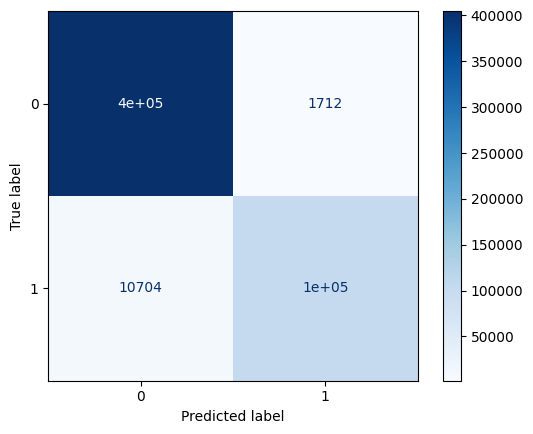

                precision    recall  f1-score   support

Normal Traffic       0.97      1.00      0.98    406465
        Attack       0.98      0.91      0.94    113471

      accuracy                           0.98    519936
     macro avg       0.98      0.95      0.96    519936
  weighted avg       0.98      0.98      0.98    519936



In [68]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))

In [69]:
# Save the trained model
model.save("cic_iot_pcap_final.keras")

# Integrated gradient

In [46]:
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape) # średnia / średnia normalnych / mediana normalnych ?? 

    interpolated_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]

    grads = []
    for inp in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
        grad = tape.gradient(pred, inp)
        grads.append(grad.numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (input_tensor.numpy() - baseline.numpy()) * avg_grads
    return integrated_grads.squeeze()

def compute_ig_for_samples(model, X_subset, steps=50, max_samples=100, baseline=None):
    attributions_list = []
    for i in range(min(len(X_subset), max_samples)):
        input_sample = tf.convert_to_tensor([X_subset[i]], dtype=tf.float32)
        ig = compute_integrated_gradients(model, input_sample, baseline=baseline, steps=steps)
        attributions_list.append(ig)
    return np.array(attributions_list)

# Separate test samples
X_normal_test = X_test[y_test == 0]
X_attack_test = X_test[y_test == 1]


In [47]:
a_normal_min = X_normal_test.shape[0] *0.01
# a_normal_max = X_normal_test.shape[0] *0.05

a_attack_min = X_attack_test.shape[0] *0.01
# a_attack_max = X_attack_test.shape[0] *0.05

a_normal_min, a_attack_min

(4064.64, 1993.82)

In [48]:
import pandas as pd
import tensorflow as tf

# Compute IG
normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=4000)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=2000)

# Average IG
avg_normal_ig = np.mean(normal_attributions, axis=0)
avg_attack_ig = np.mean(attack_attributions, axis=0)


In [49]:
# Normal
df_normal = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_ig)),
    "Attribution (Normal Class)": avg_normal_ig
})
df_normal["Abs Attribution"] = np.abs(df_normal["Attribution (Normal Class)"])
df_normal_sorted = df_normal.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_ig)),
    "Attribution (Attack Class)": avg_attack_ig
})
df_attack["Abs Attribution"] = np.abs(df_attack["Attribution (Attack Class)"])
df_attack_sorted = df_attack.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_sorted.head(20), df_attack_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 59          59                   -0.319039         0.319039
 63          63                   -0.143651         0.143651
 34          34                   -0.116795         0.116795
 56          56                    0.110734         0.110734
 57          57                    0.086814         0.086814
 18          18                    0.082531         0.082531
 19          19                    0.066226         0.066226
 36          36                    0.048383         0.048383
 58          58                   -0.046692         0.046692
 35          35                   -0.045257         0.045257
 20          20                   -0.044114         0.044114
 15          15                   -0.041257         0.041257
 43          43                   -0.038754         0.038754
 98          98                    0.032034         0.032034
 38          38                    0.027528         0.027528
 24          24         

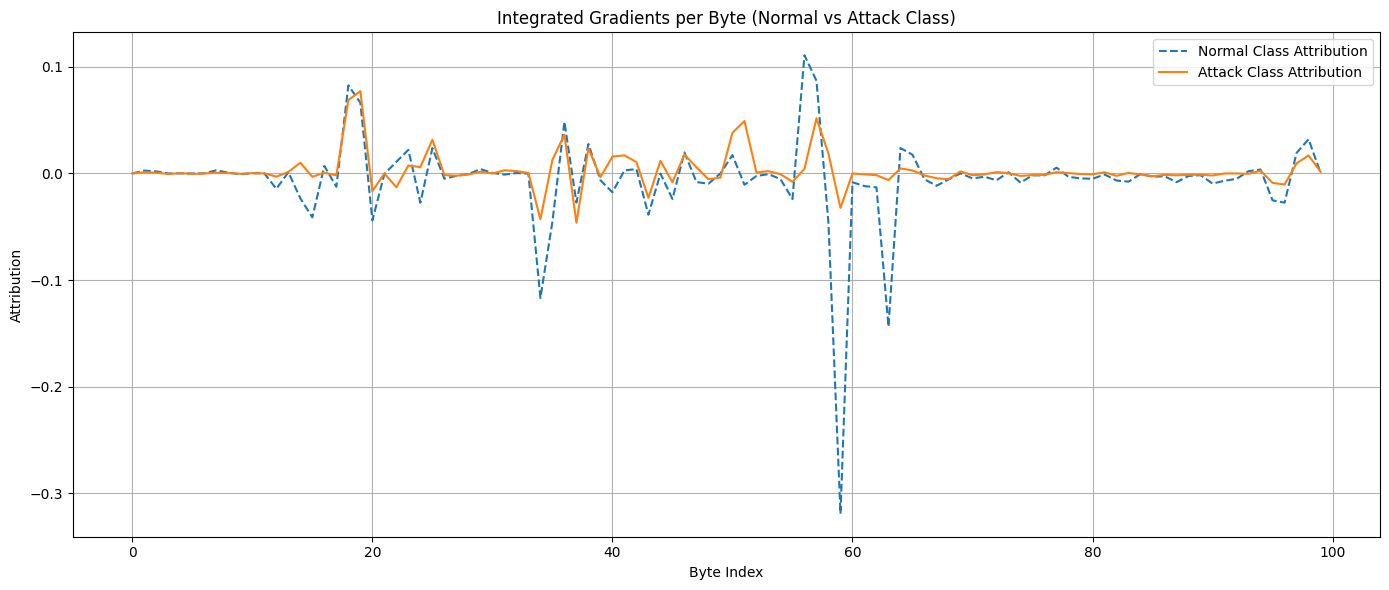

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Baseline - mean

In [51]:
# mean of normal test samples as a baseline
normal_mean = np.mean(X_normal_test, axis=0)
baseline_tensor = tf.convert_to_tensor([normal_mean], dtype=tf.float32)

normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=4000, baseline=baseline_tensor)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=2000, baseline=baseline_tensor)


In [52]:
# Average IG
avg_normal_mean_ig = np.mean(normal_attributions, axis=0)
avg_attack_mean_ig = np.mean(attack_attributions, axis=0)

In [53]:
# Normal
df_normal_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_mean_ig)),
    "Attribution (Normal Class)": avg_normal_mean_ig
})
df_normal_mean["Abs Attribution"] = np.abs(df_normal_mean["Attribution (Normal Class)"])
df_normal_mean_sorted = df_normal_mean.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_mean_ig)),
    "Attribution (Attack Class)": avg_attack_mean_ig
})
df_attack_mean["Abs Attribution"] = np.abs(df_attack_mean["Attribution (Attack Class)"])
df_attack_mean_sorted = df_attack_mean.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_mean_sorted.head(20), df_attack_mean_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 58          58                   -0.148177         0.148177
 55          55                    0.117564         0.117564
 34          34                    0.115680         0.115680
 59          59                   -0.097988         0.097988
 29          29                    0.078680         0.078680
 38          38                   -0.058038         0.058038
 62          62                   -0.057746         0.057746
 63          63                   -0.056249         0.056249
 52          52                    0.046532         0.046532
 96          96                    0.045342         0.045342
 13          13                   -0.045122         0.045122
 22          22                   -0.044452         0.044452
 98          98                   -0.037029         0.037029
 15          15                    0.034119         0.034119
 33          33                   -0.030331         0.030331
 36          36         

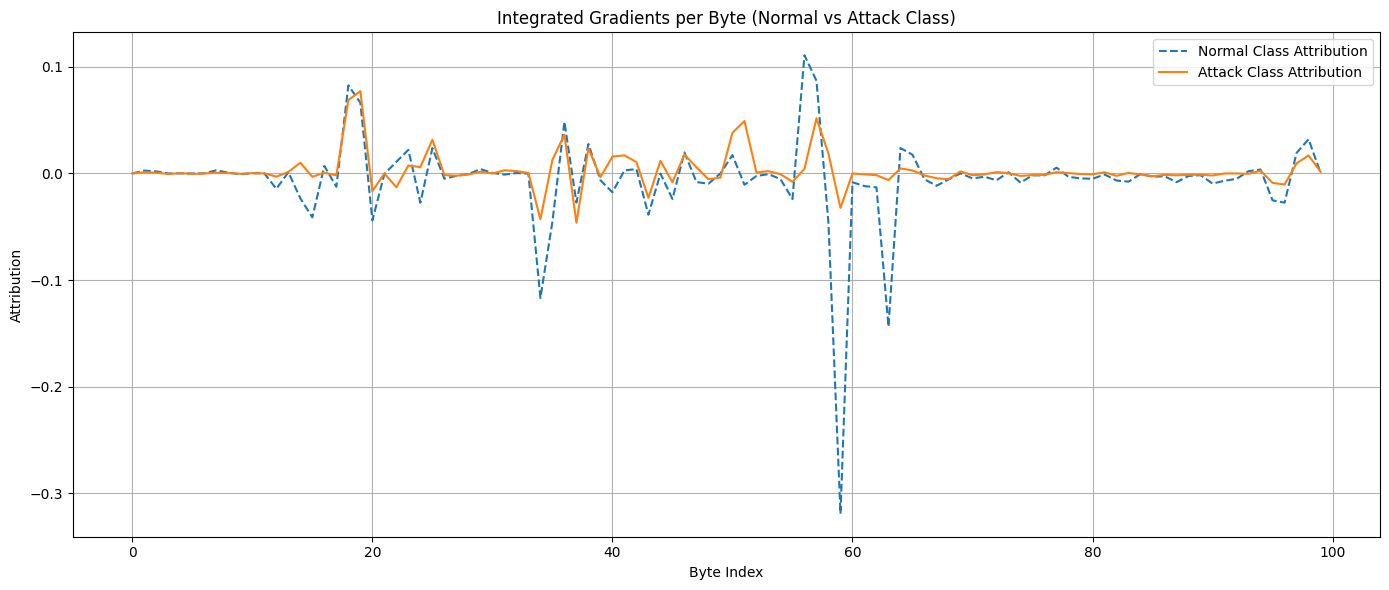

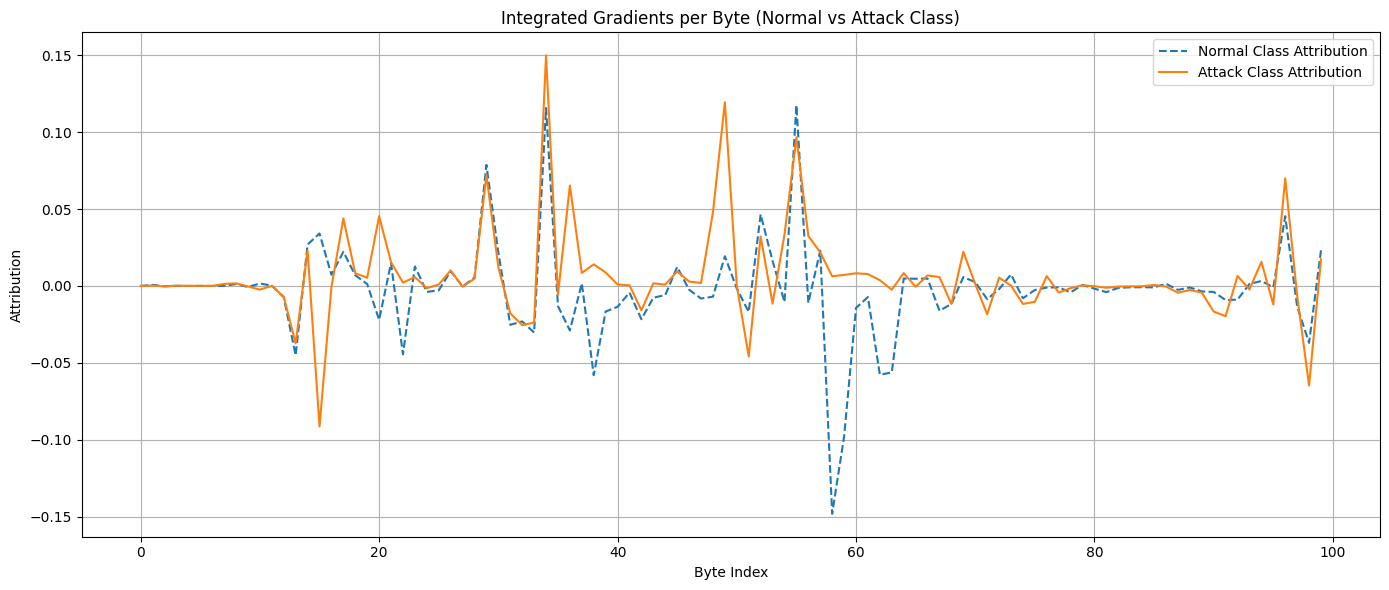

In [54]:
import matplotlib.pyplot as plt
# baseline [0..0]
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# baseline mean
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_mean_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_mean_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
from collections import Counter
from scapy.all import IP, IPv6, TCP, UDP, ICMP, ARP
from scapy.layers.inet6 import ICMPv6EchoRequest, ICMPv6EchoReply, ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6DestUnreach

def classify_packet(pkt):
    if ARP in pkt:
        return "ARP"
    if IP in pkt:
        if TCP in pkt: return "TCP"
        if UDP in pkt: return "UDP"
        if ICMP in pkt: return "ICMP"
        return "IPv4 (other)"
    if IPv6 in pkt:
        if TCP in pkt: return "TCPv6"
        if UDP in pkt: return "UDPv6"
        if any(pkt.haslayer(x) for x in (
            ICMPv6EchoRequest, ICMPv6EchoReply, ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6DestUnreach
        )):
            return "ICMPv6"
        return "IPv6 (other)"
    return "Non-IP"

def count_protocols_from_packets(packet_list):
    counts = Counter(classify_packet(pkt) for pkt in packet_list)
    total = sum(counts.values())
    print("\n=== Protocol breakdown ===")
    for proto, cnt in counts.most_common():
        print(f"{proto:20s} {cnt:10d}  ({cnt/total*100:6.2f}%)")
    print(f"\nTotal packets: {total}")
    return counts

# Example: use directly on your attack packets
counts_attack = count_protocols_from_packets(packets_attack)



=== Protocol breakdown ===
TCP                      442197  ( 77.94%)
UDP                      102584  ( 18.08%)
ARP                       12340  (  2.18%)
ICMP                       4575  (  0.81%)
Non-IP                     2910  (  0.51%)
UDPv6                      1473  (  0.26%)
IPv6 (other)                583  (  0.10%)
ICMPv6                      552  (  0.10%)
IPv4 (other)                142  (  0.03%)

Total packets: 567356


# FGSM

In [14]:
from scapy.all import rdpcap

# Load packets from pcap file
packets_attack = rdpcap(r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\anonymized_attack.pcap")

In [15]:
# Original full packets for those test attack samples
attack_test_mask = y_test == 1
X_attack_test = X_test[attack_test_mask].squeeze(axis=-1)
y_attack_test = y_test[attack_test_mask]
idx_attack_test = idx_test[attack_test_mask]

# Map test indices back to attack-only packets
# All attack packets are offset by len(X_normal)
relative_attack_indices = idx_attack_test - attack_start_idx
packets_attack_test = [packets_attack[i] for i in relative_attack_indices]

In [96]:
len(packets_attack_test)

113471

In [9]:
X_test_normal = X_test[y_test == 0]
y_test_normal = y_test[y_test == 0]

X_test_attack = X_test[y_test == 1]
y_test_attack = y_test[y_test == 1]

In [72]:
X_test_normal.shape

(406465, 100, 1)

In [73]:
def fgsm_attack(model, x, y_true, epsilon):
    x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        prediction = model(x_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, prediction)

    # Compute gradients
    gradient = tape.gradient(loss, x_adv)
    signed_grad = tf.sign(gradient)

    # Apply perturbation
    x_adv = x_adv + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # to keep values in byte range

    return x_adv


In [27]:
def fgsm_attack(model, x, y_true, epsilon=0.01):
    x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        prediction = model(x_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, prediction)

    # Compute gradients
    gradient = tape.gradient(loss, x_adv)
    signed_grad = tf.sign(gradient)

    # Apply perturbation
    x_adv = x_adv + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # to keep values in byte range

    return x_adv


In [29]:
# Generate adversarial samples
X_test_attack_adv = fgsm_attack(model, X_test_attack, y_attack_test, epsilon=0.1)


In [28]:
X_attack_test.shape

(113471, 100)

In [75]:
X_test_attack_adv.shape

TensorShape([113471, 100])

In [16]:
from scapy.all import (
    PcapWriter, Ether, IP, IPv6, UDP, TCP, Raw, Dot3, LLC, EAPOL,
    ARP, conf
)
from scapy.contrib.gtp import GTP_U_Header
import numpy as np

# Optional imports used for linktype inference on non-Ethernet pcaps
try:
    from scapy.layers.dot11 import RadioTap
except Exception:
    RadioTap = None

try:
    from scapy.layers.l2 import CookedLinux, Loopback
except Exception:
    CookedLinux = None
    Loopback = None


def is_control_or_non_ip(pkt):
    """Return True for frames we should skip outright (ARP, STP, EAPOL, LOOP, etc.)."""
    # Non-IP L2 control/management frames
    if pkt.haslayer(ARP):
        return True
    if pkt.haslayer(EAPOL):
        return True
    # STP often shows up as 802.3 + LLC + STP; Scapy may not always name it "STP"
    if pkt.haslayer(LLC):
        # Heuristic: STP uses LLC DSAP/SSAP = 0x42 (BPDU). If present, skip.
        llc = pkt[LLC]
        if getattr(llc, "dsap", None) == 0x42 or getattr(llc, "ssap", None) == 0x42:
            return True
    # Loopback frames (pcap "LOOP/Null") — nothing to patch here
    if Loopback is not None and pkt.haslayer(Loopback):
        return True
    # If there is no IP nor IPv6 anywhere (e.g., pure L2 protocol), skip
    if not (pkt.haslayer(IP) or pkt.haslayer(IPv6) or pkt.haslayer(GTP_U_Header)):
        return True
    return False


def get_inner_scope(pkt):
    """
    Return the 'scope' we should modify:
    - If GTP-U present: its payload (typically inner IP).
    - Otherwise the packet itself.
    """
    scope = pkt
    if pkt.haslayer(GTP_U_Header):
        scope = pkt[GTP_U_Header].payload
    return scope


def _get_l4(scope):
    """Return (l4_layer, is_tcp, is_udp) if TCP/UDP present; else (None, False, False)."""
    if scope.haslayer(TCP):
        return scope[TCP], True, False
    if scope.haslayer(UDP):
        return scope[UDP], False, True
    return None, False, False


def _payload_bytes(l4):
    """
    Safely extract current L4 payload as bytes even when a higher protocol
    (DNS/QUIC/….) is dissected (i.e., no Raw layer).
    """
    if l4 is None:
        return b""
    # If a Raw layer is directly present, use it
    raw = l4.getlayer(Raw)
    if raw is not None and isinstance(raw.load, (bytes, bytearray)):
        return bytes(raw.load)
    # Otherwise take bytes of the entire payload object (Scapy will serialize it)
    return bytes(l4.payload) if l4.payload is not None else b""


def _set_payload_bytes(l4, new_payload_bytes):
    """
    Replace the L4 payload with a Raw(new_payload_bytes). This discards any decoded
    higher-layer view (DNS/QUIC/etc.), which is fine for adversarial patching.
    """
    # Remove existing payload and replace with fresh Raw
    # Using .remove_payload() avoids double-encapsulation
    try:
        l4.remove_payload()
    except Exception:
        pass
    l4.add_payload(Raw(load=new_payload_bytes))


def _delete_checksums(scope, pkt):
    """Delete checksums so Scapy recomputes them on serialization."""
    try:
        if scope.haslayer(IP) and hasattr(scope[IP], "chksum"):
            del scope[IP].chksum
    except Exception:
        pass
    try:
        if scope.haslayer(IPv6) and hasattr(scope[IPv6], "plen"):
            # IPv6 has no header checksum; leave plen alone (Scapy will set it).
            pass
    except Exception:
        pass
    try:
        if scope.haslayer(TCP) and hasattr(scope[TCP], "chksum"):
            del scope[TCP].chksum
    except Exception:
        pass
    try:
        if scope.haslayer(UDP) and hasattr(scope[UDP], "chksum"):
            del scope[UDP].chksum
    except Exception:
        pass
    # If we patched inside GTP-U carried over UDP on the outer IP, outer UDP chksum must be reset
    try:
        if pkt.haslayer(UDP) and hasattr(pkt[UDP], "chksum"):
            del pkt[UDP].chksum
    except Exception:
        pass


def patch_payload_bytes(pkt, adv_bytes, *, skip_quic=True, min_udp_len=1):
    """
    Patch the first min(len(payload), len(adv_bytes)) bytes of the TCP/UDP payload in-place.
    - skip_quic=True: don't tamper with QUIC (often encrypted; patching breaks sessions badly).
    - min_udp_len: skip trivial keep-alives like UDP Len=4 if set > 4 (you can tune this).
    Returns a patched copy or None if the packet is to be skipped.
    """
    if is_control_or_non_ip(pkt):
        return None

    pkt = pkt.copy()
    scope = get_inner_scope(pkt)
    l4, is_tcp, is_udp = _get_l4(scope)
    if l4 is None:
        return None

    # Optional: skip QUIC (typically UDP port 443, 784, 853? main one is 443)
    if skip_quic and is_udp:
        sport = int(getattr(l4, "sport", 0) or 0)
        dport = int(getattr(l4, "dport", 0) or 0)
        if 443 in (sport, dport):
            return None

    payload = _payload_bytes(l4)
    if not payload:
        # TCP ACKs with Len=0, empty UDP, etc.
        return None

    # Skip tiny UDP keepalives if desired
    if is_udp and len(payload) < min_udp_len:
        return None

    # Ensure adv_bytes is bytes
    adv_bytes = np.asarray(adv_bytes, dtype=np.uint8).ravel().tobytes()

    # Patch into a bytearray and reassign as Raw
    patched = bytearray(payload)
    n = min(len(patched), len(adv_bytes))
    patched[:n] = adv_bytes[:n]
    _set_payload_bytes(l4, bytes(patched))

    # Recompute checksums (inner + outer)
    _delete_checksums(scope, pkt)
    return pkt


def _infer_linktype(p0):
    """
    Infer pcap linktype (DLT_*). This is best-effort; choose the one that matches the capture.
    """
    # Ethernet
    if p0.haslayer(Ether):
        return 1  # DLT_EN10MB
    # 802.11 with radiotap
    if RadioTap is not None and p0.haslayer(RadioTap):
        return 127  # DLT_IEEE802_11_RADIO
    # Linux cooked capture (SLL / SLL2)
    if CookedLinux is not None and p0.haslayer(CookedLinux):
        # Scapy tends to use SLL (DLT 113). SLL2 is 276 but rarer.
        return 113  # DLT_LINUX_SLL
    # Loopback / Null
    if Loopback is not None and p0.haslayer(Loopback):
        return 0  # DLT_NULL
    # Fallback to Ethernet
    return 1


def save_patched_packets(original_packets, x_adv_uint8, output_path,
                         *, skip_quic=True, min_udp_len=1, verbose=True):
    """
    Iterate packets + corresponding adversarial bytes and write patched ones to a pcap.
    Skips non-app/control frames common in IoT traces.
    """
    assert len(original_packets) >= 1, "original_packets must be non-empty"
    writer = PcapWriter(output_path, linktype=_infer_linktype(original_packets[0]), sync=True)

    total = saved = skipped = 0
    for orig_pkt, adv in zip(original_packets, x_adv_uint8):
        total += 1
        pkt = patch_payload_bytes(orig_pkt, adv, skip_quic=skip_quic, min_udp_len=min_udp_len)
        if pkt is None:
            skipped += 1
            continue
        writer.write(pkt)
        saved += 1

    writer.close()
    if verbose:
        print(f"✅ Saved {saved}/{total} IoT-patched packets to {output_path} (skipped {skipped})")


In [84]:
assert len(packets_attack_test) == len(x_adv_uint8)
save_patched_packets(
    packets_attack_test,
    x_adv_uint8,
    r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\fgsm_full_modified2.pcap"
)


✅ Saved 96183/113471 IoT-patched packets to C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\fgsm_full_modified2.pcap (skipped 17288)


In [79]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_adv.numpy() * 255).astype(np.uint8)

X_test_attack_adv_np = (
    X_test_attack_adv.numpy() if tf.is_tensor(X_test_attack_adv) else np.asarray(X_test_attack_adv)
)
X_test_attack_adv_np = X_test_attack_adv_np[..., np.newaxis]

# Stack with normal test samples
X_test = np.vstack((X_test_normal, X_test_attack_adv_np))
y_test = np.hstack((y_test_normal, y_attack_test))


In [30]:
X_test = np.vstack((X_test_normal, X_test_attack_adv))
y_test = np.hstack((y_test_normal, y_attack_test))

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

16248/16248 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Accuracy: 0.84
Precision: 0.95
Recall: 0.30


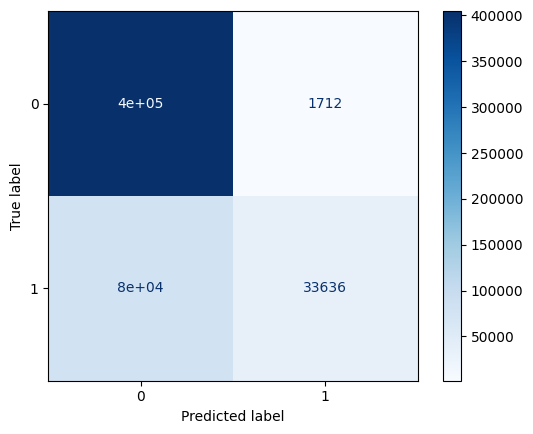

                precision    recall  f1-score   support

Normal Traffic       0.84      1.00      0.91    406465
        Attack       0.95      0.30      0.45    113471

      accuracy                           0.84    519936
     macro avg       0.89      0.65      0.68    519936
  weighted avg       0.86      0.84      0.81    519936



In [32]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

# FGSM - targeted byte positions only

In [77]:
import numpy as np
import tensorflow as tf

def fgsm_attack_constrained_fields(
    model,
    X_attack,
    y_true,
    epsilon=0.01,
    # byte indices (0-based) for the modifiable fields you specified
    indices_single=(15, 46),          # ECN byte (but only 2 LSBs), TTL, NS flag byte
    indices_pairs=((18,19), (34,35), (48,49)),  # ip.id, tcp.srcport, tcp.window_size
):
    """
    Perform FGSM on selected header bytes while enforcing protocol-valid constraints.

    Args:
        model: tf.keras model taking input shaped (N,100,1) with values in [0,1] (we normalize internally).
        X_attack: np.ndarray of shape (N,100,1), dtype uint8, raw bytes [0..255].
        y_true: ground-truth labels, shape (N,) or (N,1); binary {0,1}. We assume '1' = attack.
        epsilon: FGSM step size in input-normalized units (i.e., for inputs scaled to [0,1]).
        indices_single: tuple of single-byte indices we will perturb (ECN/TTL/NS; ECN & NS are post-processed).
        indices_pairs: tuple of 2-tuples for 16-bit fields (ip.id, srcport, window size).

    Returns:
        x_adv_uint8: np.ndarray of shape (N,100,1), dtype uint8, adversarial bytes [0..255].
    """
    # Ensure correct dtypes/shapes
    x_bytes = X_attack.astype(np.uint8)
    n, L, C = x_bytes.shape
    assert L == 100 and C == 1, f"Expected (N,100,1), got {x_bytes.shape}"

    # float32 for gradient computation
    x_norm = x_bytes.astype(np.float32)
    x_tensor = tf.convert_to_tensor(x_norm)
    y_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_tensor = tf.reshape(y_tensor, (-1, 1))

    # Compute gradient of loss w.r.t. inputs
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        preds = model(x_tensor)
        loss = tf.keras.losses.binary_crossentropy(y_tensor, preds)

    grad = tape.gradient(loss, x_tensor)                   # shape (N,100,1)
    signed_grad = tf.sign(grad)

    # Build a mask that allows perturbations ONLY on the requested indices
    mask = np.zeros_like(x_norm, dtype=np.float32)         # (N,100,1)

    # Single-byte indices
    for idx in indices_single:
        mask[:, idx, 0] = 1.0

    # Two-byte (16-bit) fields
    for i, j in indices_pairs:
        mask[:, i, 0] = 1.0
        mask[:, j, 0] = 1.0

    mask_tf = tf.convert_to_tensor(mask, dtype=tf.float32)

    # FGSM step on allowed positions only
    x_adv_norm = x_tensor + epsilon * signed_grad * mask_tf
    x_adv_norm = tf.clip_by_value(x_adv_norm, 0.0, 1.0)

    # Convert back to bytes
    x_adv = tf.round(x_adv_norm * 255.0)
    x_adv = tf.clip_by_value(x_adv, 0.0, 255.0)
    x_adv_uint8 = x_adv.numpy().astype(np.uint8)

    # -------- Post-processing to enforce protocol constraints --------

    # We need numpy views of gradients too (for ECN/NS decisions)
    sgn = signed_grad.numpy()

    # 1) ip.dsfield.ecn at byte 15: keep DSCP (upper 6 bits) from ORIGINAL,
    #    adjust only the ECN code (lower 2 bits) by ±1 based on grad sign.
    idx_ecn = 15
    orig_dscp = (x_bytes[:, idx_ecn, 0] >> 2).astype(np.uint8)     # upper 6 bits
    orig_ecn  = (x_bytes[:, idx_ecn, 0] & 0b11).astype(np.uint8)   # lower 2 bits
    grad_ecn  = sgn[:, idx_ecn, 0]

    ecn_new = orig_ecn.copy()
    ecn_new = np.where(grad_ecn > 0, np.minimum(ecn_new + 1, 3), ecn_new)
    ecn_new = np.where(grad_ecn < 0, np.maximum(ecn_new - 1, 0), ecn_new)
    x_adv_uint8[:, idx_ecn, 0] = ((orig_dscp << 2) | ecn_new).astype(np.uint8)

    # 3) tcp.flags.ns at byte 46: force to {0,1}
    idx_ns = 46
    grad_ns = sgn[:, idx_ns, 0]
    # If grad > 0 => 1; grad < 0 => 0; grad == 0 => keep original 0/1 (masked to LSB)
    orig_ns = (x_bytes[:, idx_ns, 0] & 1).astype(np.uint8)
    ns_new = orig_ns.copy()
    ns_new = np.where(grad_ns > 0, 1, ns_new)
    ns_new = np.where(grad_ns < 0, 0, ns_new)
    x_adv_uint8[:, idx_ns, 0] = ns_new.astype(np.uint8)

    # 4) tcp.srcport bytes 34–35: ensure 16-bit port in [1, 65535] (port 0 invalid)
    i_sp, j_sp = 34, 35
    sp = (x_adv_uint8[:, i_sp, 0].astype(np.uint16) << 8) | x_adv_uint8[:, j_sp, 0].astype(np.uint16)
    sp = np.where(sp == 0, 1, sp)   # force nonzero
    x_adv_uint8[:, i_sp, 0] = (sp >> 8).astype(np.uint8)
    x_adv_uint8[:, j_sp, 0] = (sp & 0xFF).astype(np.uint8)

    # 5) ip.id (18–19): no extra constraint needed (any 0..65535 valid)
    # 6) tcp.window_size_value (48–49): no extra constraint needed (0..65535 valid)

    # 6) tcp.window_size_value @ 48–49: force > 0  (i.e., [1..65535])
    i_ws, j_ws = 48, 49
    ws = (x_adv_uint8[:, i_ws, 0].astype(np.uint16) << 8) | x_adv_uint8[:, j_ws, 0].astype(np.uint16)
    ws = np.where(ws == 0, 1, ws)
    x_adv_uint8[:, i_ws, 0] = (ws >> 8).astype(np.uint8)
    x_adv_uint8[:, j_ws, 0] = (ws & 0xFF).astype(np.uint8)

    return x_adv_uint8


In [78]:
X_attack_test.shape

(113471, 100)

In [94]:
X_test_attack.shape

(113471, 100, 1)

In [103]:
# FGSM attack on selected bytes
x_adv = fgsm_attack_constrained_fields(model, X_test_attack, y_attack_test, epsilon=0.1)


In [109]:
X_attack_adv = X_attack_adv[..., np.newaxis]
print(X_attack_adv.shape)

(113471, 100, 1)


In [110]:
# Stack with normal test samples
X_adv_eval = x_adv.astype(np.float32) / 255.0
X_test = np.vstack((X_test_normal, X_adv_eval))
y_test = np.hstack((y_test_normal, y_attack_test))

In [111]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

16248/16248 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
Accuracy: 0.78
Precision: 0.27
Recall: 0.01


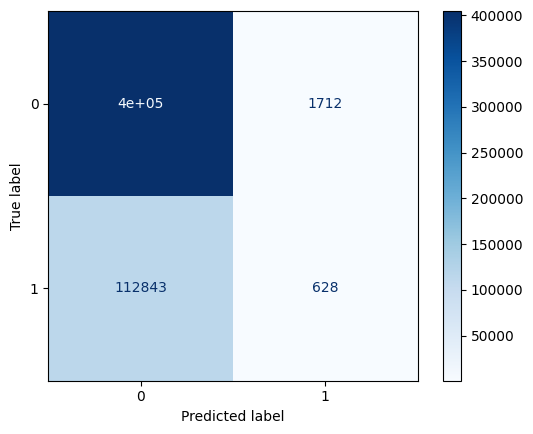

                precision    recall  f1-score   support

Normal Traffic       0.78      1.00      0.88    406465
        Attack       0.27      0.01      0.01    113471

      accuracy                           0.78    519936
     macro avg       0.53      0.50      0.44    519936
  weighted avg       0.67      0.78      0.69    519936



In [112]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

In [84]:
# pip install scapy
from scapy.all import Ether, IP, TCP, wrpcap
import numpy as np

def _u16(msb, lsb):
    return ((int(msb) & 0xFF) << 8) | (int(lsb) & 0xFF)

def _clip(v, lo, hi):
    return max(lo, min(int(v), hi))

def apply_adv_vec_to_iot_packet(pkt, adv_vec_100, enforce_ephemeral_srcport=False):
    if not (IP in pkt and TCP in pkt):
        return pkt

    v = np.asarray(adv_vec_100).squeeze()
    if v.ndim != 1 or v.shape[0] < 50:
        raise ValueError(f"adv_vec_100 must be length 100 (got shape {v.shape})")
    if v.dtype.kind in ("f", "F"):
        v = np.clip(np.rint(v * 255.0), 0, 255).astype(np.uint8)
    else:
        v = v.astype(np.uint8)

    p = pkt.copy()

    # --- ip.dsfield.ecn ---
    orig_tos = int(getattr(p[IP], "tos", 0))
    orig_dscp = (orig_tos & 0xFC)
    ecn_new = int(v[15]) & 0x03
    p[IP].tos = orig_dscp | ecn_new

    # --- ip.id ---
    p[IP].id = _u16(v[18], v[19])

    # --- ip.ttl ---
    # p[IP].ttl = _clip(v[22], 1, 255)

    # --- tcp.srcport ---
    sport = _u16(v[34], v[35]) or 1
    if enforce_ephemeral_srcport and sport < 1024:
        sport = 1024
    p[TCP].sport = sport

    # --- tcp.flags.NS ---
    ns_new = int(v[46]) & 0x01
    p[TCP].reserved = ns_new  # NS bit is stored in "reserved"

    # --- tcp.window ---
    win = _u16(v[48], v[49]) or 1
    p[TCP].window = win

    # --- Recompute header-dependent fields ---
    for fld in ("len", "chksum"):
        if hasattr(p[IP], fld):
            delattr(p[IP], fld)
    for fld in ("dataofs", "chksum"):
        if hasattr(p[TCP], fld):
            delattr(p[TCP], fld)

    return Ether(bytes(p))


def save_adv_iot_packets_to_pcap(packets_attack, x_adv, out_path="adversarial_attacks_fixed.pcap",
                                 enforce_ephemeral_srcport=False):
    """
    x_adv: (N,100,1) or (N,100), uint8 or floats in [0,1].
    Only IP/TCP packets are modified; others copied as-is.
    """
    X = np.asarray(x_adv)
    if X.ndim == 3 and X.shape[2] == 1:
        X = X[:, :, 0]
    elif X.ndim != 2 or X.shape[1] != 100:
        raise ValueError(f"x_adv must be (N,100,1) or (N,100); got {x_adv.shape}")

    N = X.shape[0]
    out_packets, modified, total = [], 0, 0

    for i, pkt in enumerate(packets_attack):
        total += 1
        if i < N:
            new_pkt = apply_adv_vec_to_iot_packet(
                pkt, X[i], enforce_ephemeral_srcport=enforce_ephemeral_srcport
            )
            if bytes(new_pkt) != bytes(pkt):
                modified += 1
            out_packets.append(new_pkt)
        else:
            out_packets.append(pkt)

    wrpcap(out_path, out_packets)
    print(f"✅ Saved {len(out_packets)} packets to {out_path} "
          f"(modified {modified}/{min(N,total)} IP/TCP packets).")


In [106]:
# x_adv: (113471, 100, 1), dtype uint8 or floats in [0,1]
# packets_attack: loaded with scapy.rdpcap(...)
save_adv_iot_packets_to_pcap(packets_attack_test, x_adv, r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\cic_iot_fgsm_fixed.pcap",
                             enforce_ephemeral_srcport=True)  # optional


✅ Saved 113471 packets to C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\cic_iot_fgsm_fixed.pcap (modified 88328/113471 IP/TCP packets).


In [114]:
from scapy.all import rdpcap, IP, TCP, UDP, ICMP, ARP
from collections import Counter

def analyze_attack_pcap(packets):
    # packets = rdpcap(pcap_path)
    proto_counts = Counter()

    for pkt in packets:
        if IP in pkt:
            ip_proto = pkt[IP].proto
            if ip_proto == 6:
                proto_counts["TCP"] += 1
            elif ip_proto == 17:
                proto_counts["UDP"] += 1
            elif ip_proto == 1:
                proto_counts["ICMP"] += 1
            else:
                proto_counts[f"IP_proto_{ip_proto}"] += 1
        elif ARP in pkt:
            proto_counts["ARP"] += 1
        else:
            proto_counts["Other"] += 1

    total = sum(proto_counts.values())
    print(f"Total packets: {total}")
    for proto, cnt in proto_counts.most_common():
        print(f"{proto:<8} {cnt:>8} ({cnt/total:.2%})")

    return proto_counts

# Example usage
counts = analyze_attack_pcap(packets_attack_test)


Total packets: 113471
TCP         88328 (77.84%)
UDP         17867 (15.75%)
IP_proto_47     2699 (2.38%)
ARP          2483 (2.19%)
Other        1126 (0.99%)
ICMP          942 (0.83%)
IP_proto_2       26 (0.02%)


# ZOO

In [5]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\ulami\Desktop\magisterka\cic_iot_pcap_final.keras")   

In [6]:
import numpy as np
import tensorflow as tf

def _bce_loss_from_logits_or_probs(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def _model_loss(model, x, y_true, targeted=False, y_target=None):
    x_tensor = tf.convert_to_tensor(x[None, ...], dtype=tf.float32)  # shape (1,H,W,1)
    pred = model(x_tensor)

    if targeted:
        if y_target is None:
            raise ValueError("y_target must be provided for targeted=True")
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_target)]], dtype=tf.float32), pred)
        # targeted: minimize loss toward y_target
        return loss[0]
    else:
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_true)]], dtype=tf.float32), pred)
        # untargeted: maximize loss w.r.t true label -> return +loss
        return loss[0]

def _zoo_estimate_grad(model, x, y_true, coords, fd_eta, targeted=False, y_target=None):
    """
    Symmetric finite-difference gradient estimate on selected flat coords.
    Supports ANY x shape (e.g., (L,1), (L,), (H,W), (H,W,C)).
    Returns grad_est with same shape as x (np.float32).
    """
    x = x.astype(np.float32, copy=True)
    orig_shape = x.shape

    x_flat = x.reshape(-1)
    grad_flat = np.zeros_like(x_flat, dtype=np.float32)

    for idx in coords:
        orig = x_flat[idx]

        # +eta
        x_flat[idx] = np.clip(orig + fd_eta, 0.0, 1.0)
        f_plus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # -eta
        x_flat[idx] = np.clip(orig - fd_eta, 0.0, 1.0)
        f_minus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # restore
        x_flat[idx] = orig

        grad_flat[idx] = (f_plus - f_minus) / (2.0 * fd_eta)

    return grad_flat.reshape(orig_shape)

def zoo_attack(
    model,
    x,
    y_true,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng=None,
    verbose=False
):
    """
    ZOO attack for a single sample x with ANY shape (e.g., (L,1) for Conv1D).
    L_inf constraint with radius epsilon around original x.
    """
    if rng is None:
        rng = np.random.default_rng()

    x0 = x.astype(np.float32).copy()
    x_adv = x0.copy()

    flat_len = x_adv.size
    all_coords = np.arange(flat_len)

    for t in range(iters):
        coords = rng.choice(all_coords, size=min(coord_batch, flat_len), replace=False)

        g = _zoo_estimate_grad(model, x_adv, y_true, coords, fd_eta, targeted=targeted, y_target=y_target)

        # Make sparse update only on sampled coords (optional)
        if coord_batch < flat_len:
            mask = np.zeros(flat_len, dtype=np.float32)
            mask[coords] = 1.0
            g = (g.reshape(-1) * mask).reshape(x_adv.shape)

        step = -lr * np.sign(g) if targeted else lr * np.sign(g)
        x_adv = x_adv + step

        # Project to L_inf ball around x0 and clip to [0,1]
        x_adv = np.clip(x_adv, x0 - epsilon, x0 + epsilon)
        x_adv = np.clip(x_adv, 0.0, 1.0)

        if verbose and (t % max(1, iters // 10) == 0 or t == iters - 1):
            current_loss = float(_model_loss(model, x_adv, y_true, targeted, y_target))
            print(f"[ZOO] iter {t+1}/{iters} | loss={current_loss:.6f}")

    return x_adv.astype(np.float32)


from tqdm import tqdm

def zoo_attack_batch(
    model,
    X,
    y,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng_seed=42,
    verbose_every=0
):
    """
    Batched convenience wrapper over zoo_attack with tqdm progress bar.
    X: (N,H,W,1) in [0,1]
    y: (N,) in {0,1}
    Returns X_adv of same shape.
    """
    rng = np.random.default_rng(rng_seed)
    X_adv = np.empty_like(X, dtype=np.float32)
    N = X.shape[0]

    for i in tqdm(range(N), desc="ZOO attack samples"):
        ve = (verbose_every and ((i % verbose_every) == 0))
        X_adv[i] = zoo_attack(
            model,
            X[i],
            float(y[i]),
            epsilon=epsilon,
            iters=iters,
            fd_eta=fd_eta,
            lr=lr,
            coord_batch=coord_batch,
            targeted=targeted,
            y_target=(int(y_target) if y_target is not None else None),
            rng=rng,
            verbose=ve
        )
    return X_adv

In [10]:

X_test_attack_zoo = zoo_attack_batch(
    model,
    X_test_attack[:200],  
    y_test_attack[:200], 
    epsilon=0.2,
    iters=20,     
    fd_eta=1e-3,
    lr=0.1,
    coord_batch=248, 
    targeted=False,
    y_target=None,
    rng_seed=123,
    verbose_every=30
)

ZOO attack samples:   0%|          | 0/200 [00:00<?, ?it/s]

[ZOO] iter 1/20 | loss=0.155507
[ZOO] iter 3/20 | loss=1.711522
[ZOO] iter 5/20 | loss=0.799121
[ZOO] iter 7/20 | loss=4.647688
[ZOO] iter 9/20 | loss=2.709004
[ZOO] iter 11/20 | loss=3.008100
[ZOO] iter 13/20 | loss=2.431445
[ZOO] iter 15/20 | loss=3.510044
[ZOO] iter 17/20 | loss=5.975039
[ZOO] iter 19/20 | loss=1.776927
[ZOO] iter 20/20 | loss=6.085797


ZOO attack samples:  15%|█▌        | 30/200 [20:35<1:56:00, 40.94s/it]

[ZOO] iter 1/20 | loss=0.350857
[ZOO] iter 3/20 | loss=1.224181
[ZOO] iter 5/20 | loss=1.552119
[ZOO] iter 7/20 | loss=0.336532
[ZOO] iter 9/20 | loss=0.556263
[ZOO] iter 11/20 | loss=0.033998
[ZOO] iter 13/20 | loss=0.157852
[ZOO] iter 15/20 | loss=1.370856
[ZOO] iter 17/20 | loss=0.067885
[ZOO] iter 19/20 | loss=2.551802
[ZOO] iter 20/20 | loss=1.362765


ZOO attack samples:  30%|███       | 60/200 [37:49<1:02:58, 26.99s/it]

[ZOO] iter 1/20 | loss=0.992717
[ZOO] iter 3/20 | loss=0.025178
[ZOO] iter 5/20 | loss=0.052409
[ZOO] iter 7/20 | loss=1.775919
[ZOO] iter 9/20 | loss=0.015561
[ZOO] iter 11/20 | loss=1.245658
[ZOO] iter 13/20 | loss=0.009077
[ZOO] iter 15/20 | loss=0.055373
[ZOO] iter 17/20 | loss=0.140623
[ZOO] iter 19/20 | loss=0.650638
[ZOO] iter 20/20 | loss=2.397099


ZOO attack samples:  45%|████▌     | 90/200 [50:57<47:06, 25.70s/it]  

[ZOO] iter 1/20 | loss=2.063495
[ZOO] iter 3/20 | loss=0.082715
[ZOO] iter 5/20 | loss=0.001322
[ZOO] iter 7/20 | loss=1.681185
[ZOO] iter 9/20 | loss=0.494215
[ZOO] iter 11/20 | loss=0.000472
[ZOO] iter 13/20 | loss=2.889003
[ZOO] iter 15/20 | loss=2.844508
[ZOO] iter 17/20 | loss=0.135346
[ZOO] iter 19/20 | loss=1.454152
[ZOO] iter 20/20 | loss=2.018425


ZOO attack samples:  60%|██████    | 120/200 [1:03:45<34:15, 25.69s/it]

[ZOO] iter 1/20 | loss=1.793841
[ZOO] iter 3/20 | loss=1.488161
[ZOO] iter 5/20 | loss=5.342638
[ZOO] iter 7/20 | loss=1.820903
[ZOO] iter 9/20 | loss=2.494778
[ZOO] iter 11/20 | loss=1.006344
[ZOO] iter 13/20 | loss=6.941879
[ZOO] iter 15/20 | loss=0.027617
[ZOO] iter 17/20 | loss=3.040059
[ZOO] iter 19/20 | loss=2.277922
[ZOO] iter 20/20 | loss=0.022316


ZOO attack samples:  75%|███████▌  | 150/200 [1:16:38<21:54, 26.29s/it]

[ZOO] iter 1/20 | loss=2.042684
[ZOO] iter 3/20 | loss=0.939097
[ZOO] iter 5/20 | loss=0.126127
[ZOO] iter 7/20 | loss=0.256995
[ZOO] iter 9/20 | loss=1.076262
[ZOO] iter 11/20 | loss=1.304017
[ZOO] iter 13/20 | loss=1.671309
[ZOO] iter 15/20 | loss=0.505328
[ZOO] iter 17/20 | loss=0.012117
[ZOO] iter 19/20 | loss=0.001051
[ZOO] iter 20/20 | loss=0.237277


ZOO attack samples:  90%|█████████ | 180/200 [1:29:27<08:31, 25.56s/it]

[ZOO] iter 1/20 | loss=1.485460
[ZOO] iter 3/20 | loss=2.729960
[ZOO] iter 5/20 | loss=0.006767
[ZOO] iter 7/20 | loss=0.721792
[ZOO] iter 9/20 | loss=0.006186
[ZOO] iter 11/20 | loss=0.058939
[ZOO] iter 13/20 | loss=1.108698
[ZOO] iter 15/20 | loss=0.004382
[ZOO] iter 17/20 | loss=1.421982
[ZOO] iter 19/20 | loss=2.376581
[ZOO] iter 20/20 | loss=2.931780


ZOO attack samples: 100%|██████████| 200/200 [1:38:00<00:00, 29.40s/it]


In [18]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_zoo * 255).astype(np.uint8)
print(len(packets_attack_test[:200]))

save_patched_packets(packets_attack_test[:200], x_adv_uint8, r"C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\CIC_zoo_full_modified.pcap")

200
✅ Saved 173/200 IoT-patched packets to C:\Users\ulami\Desktop\datasety\CIC_IOT_pcap\CIC_zoo_full_modified.pcap (skipped 27)


In [19]:
X_test_attack.shape

(113471, 100, 1)

In [11]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_test_attack_zoo))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


12709/12709 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
Test Accuracy: 99.55%
Test Precision: 99.92%
Test Recall: 99.55%


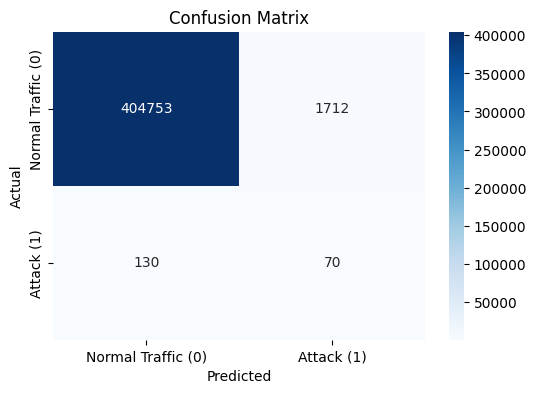

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    406465
        Attack       0.04      0.35      0.07       200

      accuracy                           1.00    406665
     macro avg       0.52      0.67      0.53    406665
  weighted avg       1.00      1.00      1.00    406665



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))
